
# Introduction 

Stock prices are anything but predictable—fluctuating with market sentiment, economic events, and company performance. But what if we could harness deep learning to uncover hidden patterns in financial data?

In this notebook I apply Long Short-Term Memory (LSTM) networks, a specialized type of recurrent neural network (RNN), to forecast **LVMH’s Opening stock Prices** based on historical market indicators. Unlike traditional models that struggle with sequential dependencies, LSTMs excel at capturing long-term trends and short-term fluctuations, making them ideal for financial time series forecasting.

Let’s dive into the data and see what the numbers reveal 

# 1. Download 3 years of LVMH stock data using yfinance

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [127]:
# Download lvmh stock data using yfinance
import yfinance as yf
ticker = "MC.PA"
# Create a Ticker object
ticker = yf.Ticker(ticker)
# Download historical data
lvmh_df = ticker.history(period="3y")

In [128]:
#keep only price data
lvmh_df=lvmh_df[["Open","High","Low","Close"]]

In [165]:
lvmh_df.head()

,Open,High,Low,Close
Date,,,,
2022-02-14 00:00:00+01:00,638.253751,639.866473,619.470433,635.597534
2022-02-15 00:00:00+01:00,633.225928,658.365234,632.372117,658.365234
2022-02-16 00:00:00+01:00,664.057207,665.575028,645.368728,652.293884
2022-02-17 00:00:00+01:00,659.219134,662.065093,640.625496,648.973633
2022-02-18 00:00:00+01:00,644.230234,658.934355,641.384275,651.060547


# 2. Explore stock time series

In [129]:
lvmh_df.dtypes, type(lvmh_df.index)

(Open     float64
 High     float64
 Low      float64
 Close    float64
 dtype: object,
 pandas.core.indexes.datetimes.DatetimeIndex)

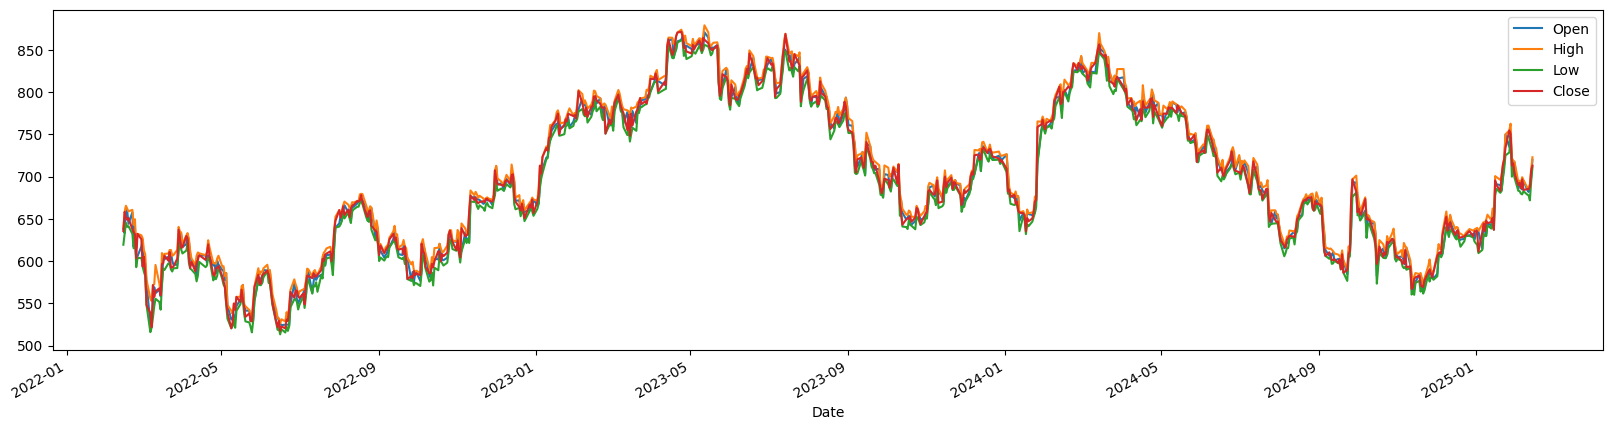

In [130]:
#plot timeseries
lvmh_df.plot(figsize=(20,5), kind="line")
plt.show()

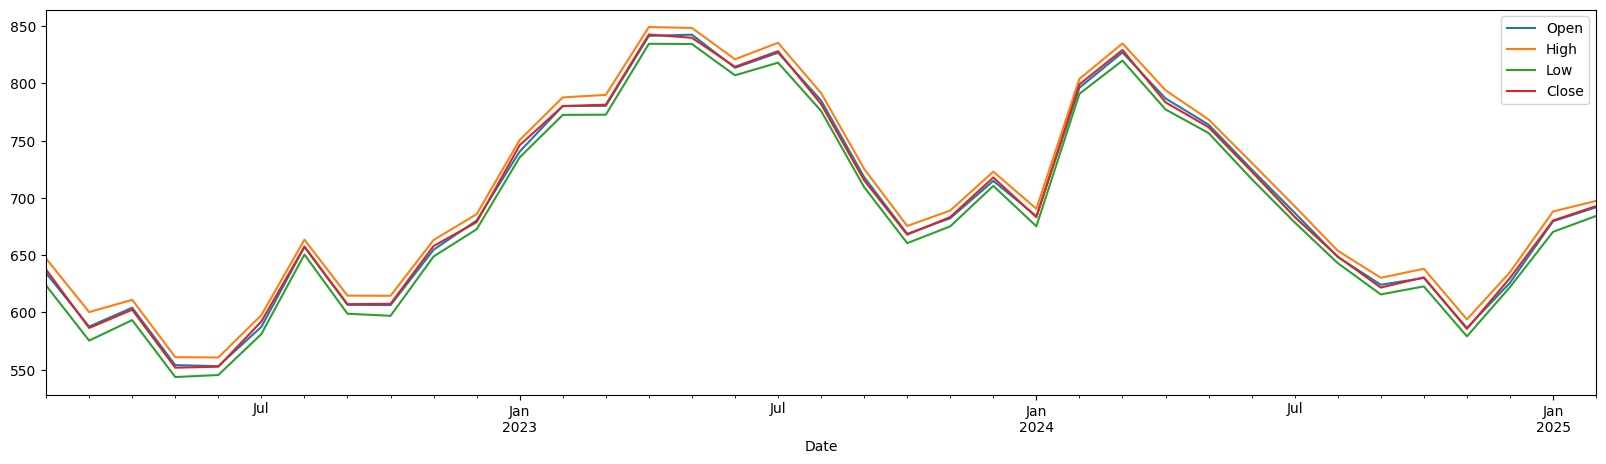

In [131]:
#Take a look at monthly resampled version
lvmh_df.resample("ME").mean().plot(figsize=(20,5), kind="line")
plt.show()

In [132]:
#Define train columns
cols=["Open","High","Low","Close"]

# 3. LSTM model for Open Price forecasting

In [133]:
# Define train and test data (keep last 3 months for test)
train_df,test_df=lvmh_df[lvmh_df.index<"2024-11-16"],lvmh_df[lvmh_df.index>"2024-11-16"]

In [134]:
# Standardize data (LSTM Gates use sigmoid and tanh that are sensible to magnitude)
scaler=StandardScaler()
scaler=scaler.fit(train_df)
scaled_train_df=scaler.transform(train_df)
scaled_test_df=scaler.transform(test_df)

## 3.1. Reformatting Time Series for One-Step-Ahead Prediction

Times series need to be reformated into LSTM sequences as follows: 

#### Training data shape

Input (trainX):   `(n_sequences x n_timesteps x n_variables)` where `n_sequences= (train_size - n_timesteps)`

Target (trainY): `(n_sequences,n_steps_ahead)`

#### Test data shape
Same structure as training data, but with: `n_sequences = (test_size - n_timesteps)`



In [135]:
# Empty lists to be populated using formatted training data
trainX = []
trainY = []

testX = []
testY = []

n_future = n_steps_ahead = 1   # Number of days we want to look into the future based on the past days.
n_past = n_timesteps = 14  # Number of past days we want to use to predict the future. 

# Reformat train  data
for i in range(n_past, len(scaled_train_df) - n_future +1):
    trainX.append(scaled_train_df[i - n_past:i, 0:train_df.shape[1]]) #Set all the 4 columns as features
    trainY.append(scaled_train_df[i + n_future - 1:i + n_future, 0]) #Set Open Price (0) as the target
    
# Reformat test data
for i in range(n_past, len(scaled_test_df) - n_future +1):
    testX.append(scaled_test_df[i - n_past:i, 0:test_df.shape[1]])
    testY.append(scaled_test_df[i + n_future - 1:i + n_future, 0])
    
# Convert list into ultidimensional arrays
trainX = np.array(trainX, dtype=np.float32)
trainY = np.array(trainY, dtype=np.float32)
testX = np.array(testX, dtype=np.float32)
testY = np.array(testY, dtype=np.float32)


In [136]:
# Check Shape
print('trainX shape : {}'.format(trainX.shape))
print('trainY shape : {}'.format(trainY.shape))
print('testX shape : {}'.format(testX.shape))
print('testY shape : {}'.format(testY.shape))

trainX shape : (694, 14, 4)
trainY shape : (694, 1)
testX shape : (48, 14, 4)
testY shape : (48, 1)


## 3.2 Train model

In [137]:
model=Sequential()
#First LSTM layer 64 nodes
model.add(LSTM(64,activation="relu",input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
#Second LSTM layer 32 nodes
model.add(LSTM(32,activation="relu",return_sequences=False))
#Dropout layer
model.add(Dropout(0.2))
#Dense layer with a single node (One step ahead forecasting)
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="Adam",loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 14, 64)            17664     
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [138]:
history=model.fit(trainX,trainY,epochs=10,batch_size=16,validation_split=0.2,verbose=1,shuffle=False)

Epoch 1/10
35/35 [==============================] - 3s 21ms/step - loss: 0.8078 - val_loss: 0.1402
Epoch 2/10
35/35 [==============================] - 0s 11ms/step - loss: 0.4471 - val_loss: 0.2505
Epoch 3/10
35/35 [==============================] - 0s 11ms/step - loss: 0.5031 - val_loss: 0.1145
Epoch 4/10
35/35 [==============================] - 0s 10ms/step - loss: 0.2335 - val_loss: 0.0877
Epoch 5/10
35/35 [==============================] - 0s 11ms/step - loss: 0.1196 - val_loss: 0.0876
Epoch 6/10
35/35 [==============================] - 0s 10ms/step - loss: 0.1190 - val_loss: 0.0731
Epoch 7/10
35/35 [==============================] - 0s 10ms/step - loss: 0.1077 - val_loss: 0.0752
Epoch 8/10
35/35 [==============================] - 0s 10ms/step - loss: 0.0995 - val_loss: 0.0582
Epoch 9/10
35/35 [==============================] - 0s 10ms/step - loss: 0.0810 - val_loss: 0.0772
Epoch 10/10
35/35 [==============================] - 0s 10ms/step - loss: 0.1000 - val_loss: 0.0694


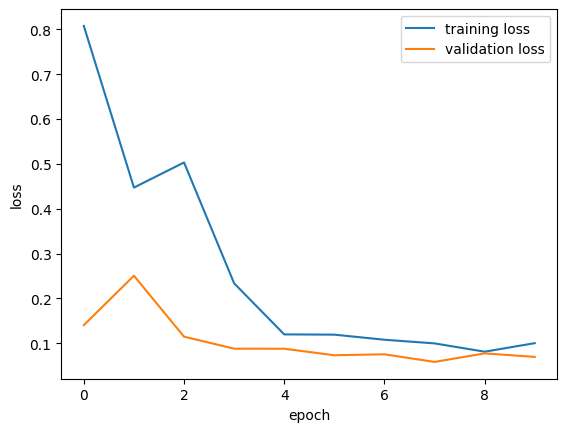

In [139]:
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")

plt.legend()
plt.show()

> <span style="color:green"> **A Good fit with just 10 epochs and 2 LSTM layers !** </span> The model trains well and generalizes effectively, showing a consistent decrease in both training and validation loss.

# 4. Test the model on the unseen data 
The model is tested on the last 3 months kept for test

In [140]:
# Predict
y_pred=model.predict(testX)

2/2 [==============================] - 0s 5ms/step


rescale data back to original range.

In [156]:
n_cols_train=train_df.shape[1]
prediction_copies = np.repeat(y_pred, n_cols_train, axis=-1)
y_pred_open=scaler.inverse_transform(prediction_copies)[:,0]

evaluate results

In [172]:
rmse=np.sqrt(mean_squared_error(y_pred_open,test_df[13:-1]['Open']))
mae= mean_absolute_error(y_pred_open,test_df[13:-1]['Open'])
print(f"RMSE {rmse:.2f}")
print(f"MAE {mae:.2f}")

RMSE 19.27
MAE 14.96


Relative error in %

In [177]:
mean_value_open = np.mean(test_df[13:-1]['Open'])
error_percentage = (mae / mean_value_open) * 100
print(f"Actual Open Price Mean : {mean_value:.2f} $")
print(f"relative error : {error_percentage:.2f} %")

Actual Open Price Mean : 663.83 $
relative error : 2.25 %


> **<span style="color:green">Good performance </span>** 🎉 : **The model's average prediction error is only 2.25% of the mean actual Open Price of 664 $. This means the model's predictions are, on average, close to the actual values.**

Plot results

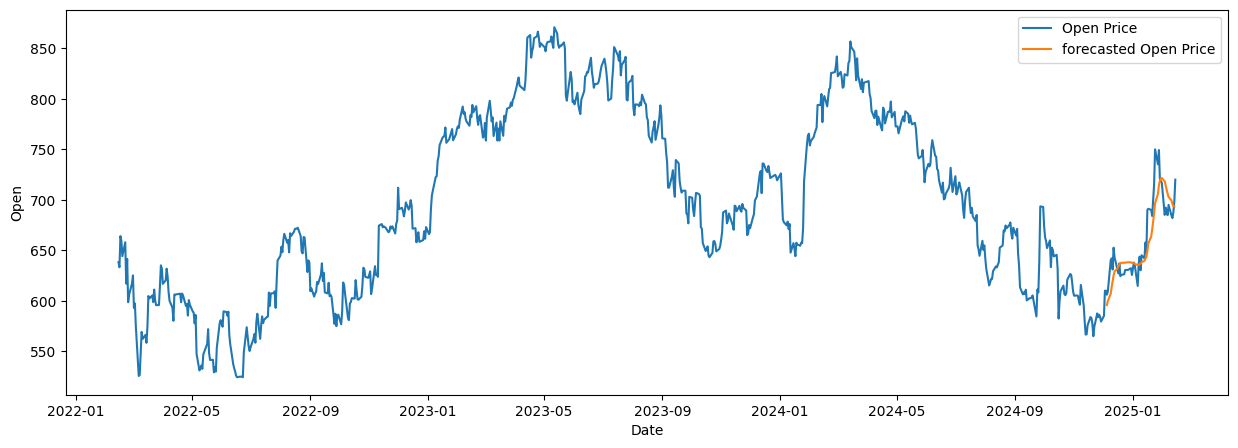

In [179]:
plt.figure(figsize=(15,5))
sns.lineplot(x=lvmh_df.index,y=lvmh_df['Open'],label="Open Price")
sns.lineplot(x=test_df[13:-1].index,y=y_pred_open,label="forecasted Open Price")
plt.show()

#### Interpretation :
> 
> The plot shows that the LSTM model is capturing the general trend of the open price. It misses some turning points, but the overall predicted trajectory is close to the actual one.

#### Areas of improvement :
**Reduce forecast smoothness** : Forcasted prices are smoother than the real prices, the model might be underestimating some fluctuations.  Using more features such as trading volume or increasing training epochs might help the model capture these fluctuations, though care must be taken to avoid overfitting

**Minimize forecast lag:** The forecast appears slightly delayed, especially in capturing sharp changes, which is often the case because rapid fluctuations are harder for models to predict in advance. Reducing window/sequence length or tweaking the number of LSTM layers/neurons might help with this.